In [2]:
using NamedTrajectories
using QuantumCollocation
using CairoMakie
using LaTeXStrings

In [19]:
data_path = "results/T_500_Δt_0.4_a_bound_0.25132741228718347_dda_bound_0.05_dt_min_0.2_dt_max_0.4_max_iter_100000_00000.jld2"
data = load_problem(data_path; return_data=true)
traj = data["trajectory"]
system = data["system"]
plot_dir = "plots/paper"
plot_path = joinpath(plot_dir, "fig_three_qubit.svg")


Loading data dict from results/T_500_Δt_0.4_a_bound_0.25132741228718347_dda_bound_0.05_dt_min_0.2_dt_max_0.4_max_iter_100000_00000.jld2:

   pade rollout fidelity = 0.9999133335752882
   exp rollout fidelity = 0.9999139155047266
   solver fidelity = 0.9999656632367825
   pulse duration = 194.56299253325216


┌ Warning: saved type Options{Float64} is missing field watchdog_shortened_iter_trigger in workspace type; reconstructing
└ @ JLD2 /home/aaron/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:164
┌ Warning: read type NamedTrajectory is not a leaf type in workspace; reconstructing
└ @ JLD2 /home/aaron/.julia/packages/JLD2/ryhNR/src/data/reconstructing_datatypes.jl:263


"plots/paper/fig_three_qubit.svg"

In [40]:
function plot_states_and_controls(
    states::AbstractMatrix{<:Real},
    controls::AbstractMatrix{<:Real},
    times::AbstractVector{<:Real};
    # style keyword arguments
    res::Tuple{Int, Int}=(1200, 900),
    titlesize::Int=36,
    series_color::Symbol=:glasbey_bw_minc_20_n256,
    ignored_labels::Union{Symbol, Vector{Symbol}, Tuple{Vararg{Symbol}}} =
        Symbol[],
    labelsize=40,
    xticksize = 35,
    yticksize = 35,
    xsize = 36,
    ysize = 36,
    title_states="States",
    labels_states=nothing,
    ylabel_states="Population",
    title_controls="Controls",
    labels_controls=[L"u_%$i" for i = 1:size(controls, 1)],
    ylabel_controls="Amplitude (GHz)",
    label_time="Time (μs)",
)

    fig = Figure(resolution=res)

    ax_states = Axis(
        fig[1, 1];
        title=title_states,
        titlesize=titlesize,
        xlabel=label_time,
        ylabel=ylabel_states,
        ylabelsize=ysize,
        xlabelsize=xsize,
        xticklabelsize=xticksize,
        yticklabelsize=yticksize
    )

    series!(ax_states, times, states; color=series_color, labels=labels_states)

    if !isnothing(labels_states)
        Legend(fig[1, 2], ax_states, labelsize=4labelsize ÷ 5, framevisible=false)
    end

    ax_controls = Axis(
        fig[2, 1];
        title=title_controls,
        titlesize=titlesize,
        xlabel=label_time,
        ylabel=ylabel_controls,
        ylabelsize=ysize,
        xlabelsize=xsize,
        xticklabelsize=xticksize,
        yticklabelsize=yticksize
    )

    series!(ax_controls, times, controls; color=series_color, labels=labels_controls)

    Legend(fig[2, 2], ax_controls, labelsize=labelsize, framevisible=false)

    return fig
end

plot_states_and_controls (generic function with 1 method)

In [34]:
traj.components
A = traj.data[traj.components.a, :]
Δts = traj.data[traj.components.Δt, :] |> vec

500-element Vector{Float64}:
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 ⋮
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375
 0.38912598506650375

In [35]:
# |100⟩ rollout test
U_goal = iso_vec_to_operator(traj.goal.Ũ⃗)
ψ = qubit_system_state("100")
ψ̃ = ket_to_iso(ψ)
ψ̃_goal = ket_to_iso(U_goal * ψ)

Ψ̃ = rollout(ψ̃, A, Δts, system)
Ψ̃_exp = rollout(ψ̃, A, Δts, system; integrator=exp);

In [36]:
fidelity(Ψ̃_exp[:,end], ψ̃_goal)

0.9999139155047266

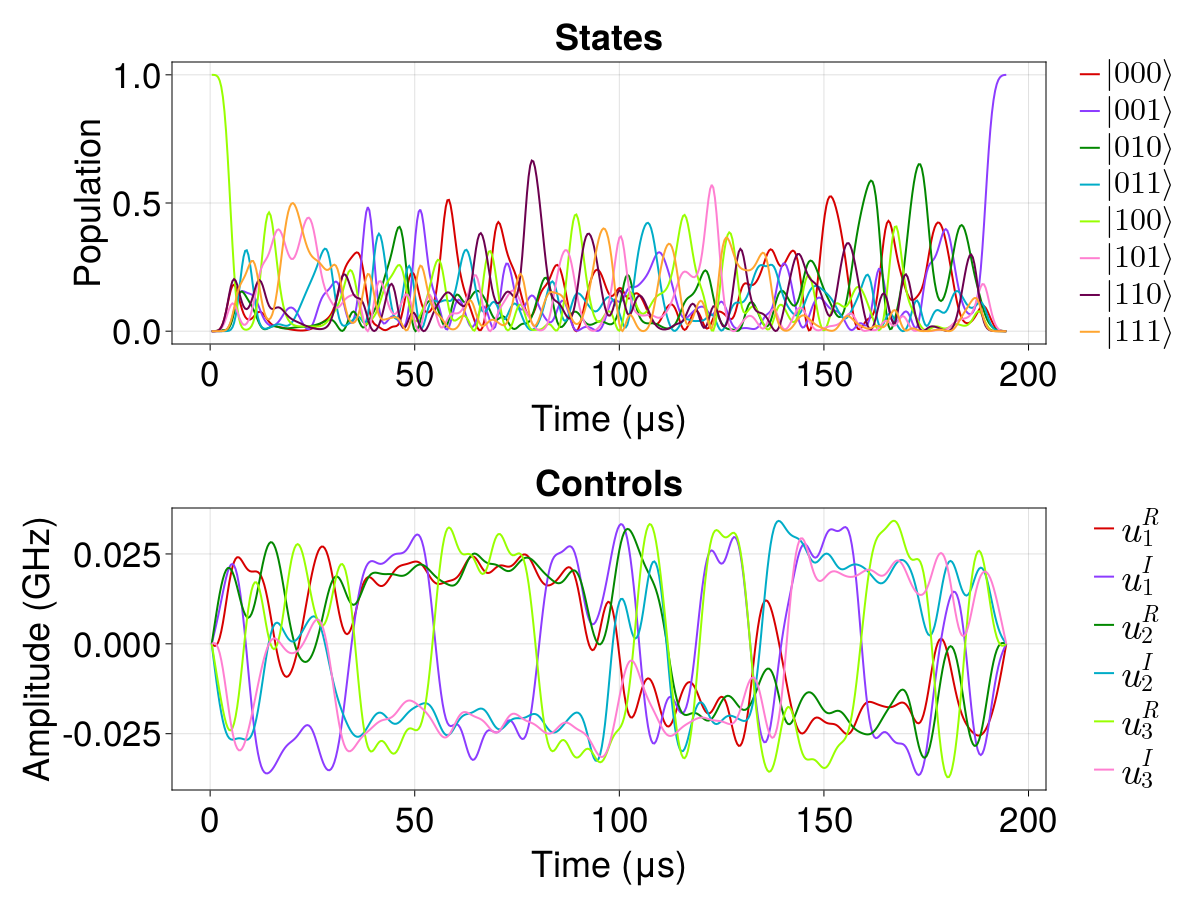

In [41]:
x = mapslices(populations, Ψ̃_exp, dims=1)
u = A ./ 2π
ts = cumsum(Δts) 

states_labels = [L"|000\rangle", L"|001\rangle", L"|010\rangle", L"|011\rangle", L"|100\rangle", L"|101\rangle", L"|110\rangle", L"|111\rangle"]

controls_labels = [L"u_1^R", L"u_1^I", L"u_2^R", L"u_2^I", L"u_3^R", L"u_3^I"]

fig = plot_states_and_controls(x, u, ts; labels_states=states_labels, labels_controls=controls_labels)

In [42]:
save(plot_path, fig)

CairoMakie.Screen{SVG}
